# Filtro colaborativo datos Steam

### Ing. Robra Abel Maximiliano

In [1]:
import gzip
import pandas as pd

def parse(path):
    g = gzip.open(path, 'r')
    for l in g:
        yield eval(l)

## 1. Partimos la información

Para el manejo de este proyecto vamos a utilizar un 10% del Dataset original entregado por Steam, ya que el mismo posee mas de 7 millones de registros lo cual vuelve complicado su manejo

<b> Atención </b>: La siguiente linea es un codigo, se debe modificar las siguientes 2 celdas por unica vez para guardar una muestra 

contador = 0
data_original = []

n = 10
for l in parse('steam_reviews.json.gz'):
    if contador%n == 0:
        data_original.append(l)
    else:
        pass
    contador += 1


data_reviews = pd.DataFrame(data_original)
data_reviews.to_csv('steam_reviews_muestra.csv')

## 2. Exploración y transformación de datos 

### Sacamos una muestra del Dataset

In [2]:
import seaborn as sns
import numpy as np
import pandas as pd

In [3]:
data_reviews = pd.read_csv('steam_reviews_muestra.csv')

In [4]:
data_reviews.head()

,Unnamed: 0,username,hours,products,product_id,page_order,date,text,early_access,page,user_id,compensation,found_funny
0,0,Chaos Syren,0.1,41.0,725280,0,2017-12-17,This would not be acceptable as an entertainme...,False,1,NaN,NaN,NaN
1,1,Ariman1,13.2,1386.0,328100,2,2017-08-02,Addictive RPG ! Works fine on linux though it ...,False,1,NaN,NaN,NaN
2,2,freakfantom,0.1,1706.0,725280,5,2017-11-12,Прикольная стрелялка. Взял дешево на распродаже.,False,1,NaN,NaN,NaN
3,3,The_Cpt_FROGGY,7.8,2217.0,631920,0,2017-12-11,Somewhere on Zibylon:\n~~~~~~~~~~~~~~~~~~\nZib...,False,1,7.656120e+16,Product received for free,NaN
4,4,the_maker988,8.2,18.0,35140,7,2018-01-02,"This game was way to linear for me, and compar...",False,1,7.656120e+16,NaN,NaN


In [5]:
data_reviews.shape

(779307, 13)

In [6]:
data_reviews.isna().sum()

Unnamed: 0           0
username            18
hours             2637
products          1566
product_id           0
page_order           0
date                 0
text              1839
early_access         0
page                 0
user_id         461967
compensation    764719
found_funny     659143
dtype: int64

In [7]:
data_reviews.describe()

,Unnamed: 0,hours,products,product_id,page_order,page,user_id,found_funny
count,779307.000000,776670.000000,777741.000000,779307.000000,779307.000000,779307.000000,3.173400e+05,120164.000000
mean,389653.000000,111.843832,236.993936,251489.822053,4.417743,893.581355,7.656120e+16,7.713125
std,224966.697452,390.145376,486.034479,149975.370469,2.897848,1928.272966,1.007694e+08,72.465816
min,0.000000,0.000000,1.000000,10.000000,0.000000,1.000000,7.656120e+16,1.000000
25%,194826.500000,4.000000,45.000000,203770.000000,2.000000,53.000000,7.656120e+16,1.000000
50%,389653.000000,15.300000,110.000000,252490.000000,4.000000,238.000000,7.656120e+16,1.000000
75%,584479.500000,59.600000,246.000000,346110.000000,7.000000,829.000000,7.656120e+16,3.000000
max,779306.000000,28164.000000,13540.000000,773900.000000,9.000000,18371.000000,7.656120e+16,6524.000000


Analizamos primero las columnas que nos pueden ser de utilidad:

Username = Ya que user_id tiene valores nulos, utilizaremos el nombre de usuario para suponer que es un usuario unico

Product_id = Usaremos esta columna ya que en si es el juego que vamos a rankear

Hours = Crearemos un ranking en función de las horas

Products = Usaremos este dato como un primer filtro, si tiene menos de 20 productos podemos tomar que es un ususario no recurrente


In [8]:
mask_products = data_reviews.products >= 20
data_reviews = data_reviews[mask_products]

In [9]:
data = pd.concat([data_reviews['username'], data_reviews['products'], data_reviews['product_id'], data_reviews['hours']], axis = 1)
data.head()

,username,products,product_id,hours
0,Chaos Syren,41.0,725280,0.1
1,Ariman1,1386.0,328100,13.2
2,freakfantom,1706.0,725280,0.1
3,The_Cpt_FROGGY,2217.0,631920,7.8
5,Szudof,155.0,288690,0.2


Como las horas jugadas serán nuestra forma de rankear el juego y asi recomendar, lo que haremos es eliminar aquellos registros que no tienen horas

In [10]:
data = data.dropna()

Ahora vamos a transformar las horas en un score de un maximo de 5 puntos


In [11]:
data.describe()

,products,product_id,hours
count,689345.000000,689345.000000,689345.000000
mean,264.617710,250888.932166,102.634905
std,507.467839,147629.508553,371.929515
min,20.000000,10.000000,0.000000
25%,63.000000,204080.000000,4.000000
50%,130.000000,251730.000000,14.700000
75%,273.000000,344850.000000,54.900000
max,13540.000000,773900.000000,28164.000000


C:\Users\Abel_\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='hours', ylabel='Density'>

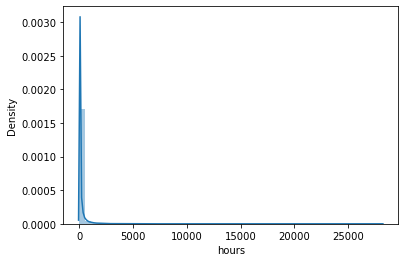

In [12]:
sns.distplot(data["hours"])

In [13]:
q25,q75, q50 = np.percentile(data.hours, [15,75, 50])

In [14]:
iqr = q75 - q25
minimo = 0
maximo = q75 + 1.5*iqr
print("Tomaremos como valor 1 desde 0 hasta " + str(q25))
print("Tomaremos como valor 2 desde " + str(q25) +" hasta " + str(q50))
print("Tomaremos como valor 3 desde " + str(q50) +" hasta " + str(q75))
print("Tomaremos como valor 4 desde " + str(q75) +" hasta " + str(maximo))
print("Tomaremos como valor 5 si supera a " + str(maximo))

Tomaremos como valor 1 desde 0 hasta 1.8
Tomaremos como valor 2 desde 1.8 hasta 14.7
Tomaremos como valor 3 desde 14.7 hasta 54.9
Tomaremos como valor 4 desde 54.9 hasta 134.55
Tomaremos como valor 5 si supera a 134.55


In [15]:
data.loc[data.hours < q25, 'ranking'] = 1
data.loc[(data.hours >= q25) & (data.hours < q50), 'ranking'] = 2
data.loc[(data.hours >= q50) & (data.hours < q75), 'ranking'] = 3
data.loc[(data.hours >= q75) & (data.hours < maximo), 'ranking'] = 4
data.loc[(data.hours > maximo), 'ranking'] = 5

C:\Users\Abel_\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='ranking', ylabel='count'>

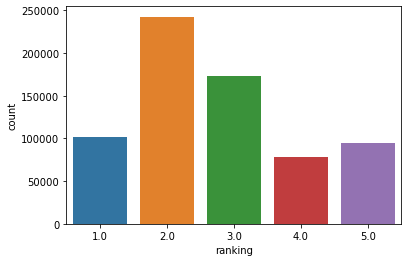

In [16]:
sns.countplot(data.ranking)

La gran parte de los juegos lo podemos encontrar entre 2 a 3 puntos, sin embargo podemos ver que existen muchos juegos en 5 puntos. El rango de horas creado tiene mucha logica teniendo en cuenta que el promedio para completar un juego es de 30 horas, por lo que podemos inferir que si no se jugo un minimo de 15 horas es un juego que no gusto o al menos no deberiamos recomendar

In [17]:
usuarios = len(data.username.unique())
rot_usuarios = int(data.shape[0])/usuarios
games = len(data.product_id.unique())
rot_games = int(data.shape[0])/games
print("Usuarios unicos son {}, rotación {}".format(usuarios,rot_usuarios))
print("Juegos unicos son {}, rotación {}".format(games,rot_games))

Usuarios unicos son 465639, rotación 1.4804279710247639
Juegos unicos son 12378, rotación 55.69114558086928


Es importante ver que a pesar de la gran cantidad de criticas, hay una media de menos de 2 de juegos jugados por el mismo usuario

Realizaremos una lista para ver cuantas criticas hay por usuario

In [18]:
list_count = data["username"].value_counts().to_numpy()

In [19]:
pd_list = pd.DataFrame()

In [20]:
pd_list["counts"] = list_count

In [21]:
porc_one = round((pd_list[pd_list.counts == 1].shape[0]/data.shape[0])*100, 2)
print("El porcentaje de usuarios con un solo valor es de {} %".format(porc_one))

El porcentaje de usuarios con un solo valor es de 52.78 %


In [22]:
porc_pocos = round((pd_list[pd_list.counts <= 3].shape[0]/data.shape[0])*100, 2)
print("El porcentaje de usuarios con menos de 3 criticas es de {} %".format(porc_pocos))

El porcentaje de usuarios con menos de 3 criticas es de 64.58 %


Como podemos ver, el 50% de los usuarios solo tiene 1 registro, y el 65% llegan a 3 criticas

### Exploración del los datos de los juegos

In [23]:
data_games = []
for l in parse('steam_games.json.gz'):
    data_games.append(l)
data_games = pd.DataFrame(data_games)

In [24]:
data_games.head()

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",4.49,http://steamcommunity.com/app/761140/reviews/?...,[Single-player],4.99,False,761140,Kotoshiro,NaN,NaN
1,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",NaN,http://steamcommunity.com/app/643980/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free To Play,False,643980,Secret Level SRL,Mostly Positive,NaN
2,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017-07-24,"[Free to Play, Simulation, Sports, Casual, Ind...",NaN,http://steamcommunity.com/app/670290/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free to Play,False,670290,Poolians.com,Mostly Positive,NaN
3,彼岸领域,"[Action, Adventure, Casual]",弹炸人2222,弹炸人2222,http://store.steampowered.com/app/767400/2222/,2017-12-07,"[Action, Adventure, Casual]",0.83,http://steamcommunity.com/app/767400/reviews/?...,[Single-player],0.99,False,767400,彼岸领域,NaN,NaN
4,NaN,NaN,Log Challenge,NaN,http://store.steampowered.com/app/773570/Log_C...,NaN,"[Action, Indie, Casual, Sports]",1.79,http://steamcommunity.com/app/773570/reviews/?...,"[Single-player, Full controller support, HTC V...",2.99,False,773570,NaN,NaN,NaN


La gran cantidad de datos puede dificultad el procesamiento, por lo que vamos a basar este filtro colaborativo en <b> generos </b>, para lo cual usaremos la información de este dataset para crear un metodo que nos permita filtras de esta manera

In [25]:
data_games.isna().sum()

publisher          8052
genres             3283
app_name              2
title              2050
url                   0
release_date       2067
tags                163
discount_price    31910
reviews_url           2
specs               670
price              1377
early_access          0
id                    2
developer          3299
sentiment          7182
metascore         29458
dtype: int64

Crearemos un dataframe solo con los datos que nos interesan de los juegos, borrando los registros nulos y cambiamos el nombre de la columna "ID" por "Product_ID" para evitar problemas

In [26]:
data_g = pd.concat([data_games['id'], data_games['app_name'],data_games['genres']], axis = 1)
data_g = data_g.dropna()
data_g.rename(columns = {'id':'product_id'},
               inplace=True)
data_g.head()

,product_id,app_name,genres
0,761140,Lost Summoner Kitty,"[Action, Casual, Indie, Simulation, Strategy]"
1,643980,Ironbound,"[Free to Play, Indie, RPG, Strategy]"
2,670290,Real Pool 3D - Poolians,"[Casual, Free to Play, Indie, Simulation, Sports]"
3,767400,弹炸人2222,"[Action, Adventure, Casual]"
5,772540,Battle Royale Trainer,"[Action, Adventure, Simulation]"


Ahora realizaremos un bucle para poder sumar todos los generos a una array que utilizaremos mas adelante para armar nuestro dataframe

In [27]:
listado = list(data_g['genres'].values)
list_genres = []

for genre in listado:
    for item in genre:
        list_genres.append(item)
list_genres = list(set(list_genres))
total_generos = len(list_genres)
print("La cantidad de generos son: {}".format(total_generos))

La cantidad de generos son: 22


In [28]:
for l in list_genres:
    data[l] = 0

In [29]:
data.head()

,username,products,product_id,hours,ranking,Massively Multiplayer,Web Publishing,Indie,Casual,Audio Production,...,Racing,Education,Photo Editing,Action,RPG,Free to Play,Design &amp; Illustration,Early Access,Video Production,Animation &amp; Modeling
0,Chaos Syren,41.0,725280,0.1,1.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Ariman1,1386.0,328100,13.2,2.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,freakfantom,1706.0,725280,0.1,1.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,The_Cpt_FROGGY,2217.0,631920,7.8,2.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,Szudof,155.0,288690,0.2,1.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Con nuestro dataset con las columnas por generos, ahora reemplazaremos los "0" por "1" en el caso que el juego este clasificado en esos generos. Cabe destacar que posiblemente no todos los juegos del dataset de juegos hayan sido jugados, asi que craremos un nuevo dataset pero con aquellos juegos que hayan sido jugado al menos 1 vez

In [30]:
data_game_rank = pd.concat([pd.DataFrame(data.groupby(['product_id'])['product_id'].count().index), pd.DataFrame(data.groupby(['product_id'])['product_id'].count().values)], axis = 1)
data_game_rank.rename(columns = {'product_id':'product_id', 0:'count'},
               inplace=True)
data_game_rank.describe()

,product_id,count
count,12378.000000,12378.000000
mean,392191.437954,55.691146
std,177063.247238,266.142164
min,10.000000,1.000000
25%,291872.500000,2.000000
50%,388310.000000,5.000000
75%,514377.500000,23.000000
max,773900.000000,11094.000000


In [31]:
data_game_rank.head()

,product_id,count
0,10,12
1,20,190
2,30,132
3,40,63
4,50,212


In [32]:
for game in data_game_rank.product_id.values:
    mask_g = (data_g.product_id == str(game))
    list_generes = data_g[mask_g].genres.values
    if len(list_generes) >= 1:
        for l in list_generes[0]:
            mask = (data.product_id == game)
            data.loc[data.product_id == game, l] = 1
    else:
        mask = (data.product_id == game)
        data.drop(data[mask].index, inplace = True)
            

In [33]:
data.head()

,username,products,product_id,hours,ranking,Massively Multiplayer,Web Publishing,Indie,Casual,Audio Production,...,Racing,Education,Photo Editing,Action,RPG,Free to Play,Design &amp; Illustration,Early Access,Video Production,Animation &amp; Modeling
0,Chaos Syren,41.0,725280,0.1,1.0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
1,Ariman1,1386.0,328100,13.2,2.0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
2,freakfantom,1706.0,725280,0.1,1.0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
3,The_Cpt_FROGGY,2217.0,631920,7.8,2.0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
5,Szudof,155.0,288690,0.2,1.0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [34]:
data.shape

(687370, 27)

Con el dataset completo, procedemos a armar el modelo

## 3. Modelo SVD 

### Modelo Benchmark

Con el resto del proyecto vamos a utilizar <b> un solo </b> genero, usaremos la metrica RMSE ya que consdiero que es la mas efectiva para medir el error

In [35]:
genero = "Sports"

### Modelo realizado con libreria surprise

Vamos a crear un modelo que utilice la información de los usuarios mas semejantes para crear un filtro colaborativo.

Importamos todas las herramientas que vamos a necesitar

In [36]:
from surprise import SVD
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import train_test_split
from surprise import accuracy

Creamos el dataset solo con el genero "sports", esto facilitara la información que maneje el algoritmo y, en teoria, deberia ayudar al filtro ya que solo se limitara a juegos del mismo genero

In [37]:
data_prueba = data
mask_prueba = (data_prueba.ranking >= 1)
mask_prueba_2 = (data_prueba[genero] == 1)
data_prueba = data_prueba[mask_prueba & mask_prueba_2]
print("Este dataset tiene {} registros".format(data_prueba.shape[0]))

Este dataset tiene 16117 registros


Como dato importante, vamos a analizar cuantos usuarios unicos hay dentro de este dataset

In [38]:
list_count_sport = data_prueba["username"].value_counts().to_numpy()
cantidad_juegos = len(data_prueba["product_id"].unique())
pd_list_sport = pd.DataFrame()
pd_list_sport["counts"] = list_count_sport
porc_one = round((pd_list_sport[pd_list_sport.counts == 1].shape[0]/data_prueba.shape[0])*100, 2)
print("El porcentaje de usuarios son un solo valor es de {} %".format(porc_one))
print("La cantidad de juegos son {}".format(cantidad_juegos))

El porcentaje de usuarios son un solo valor es de 92.32 %
La cantidad de juegos son 474


En este genero es mas evidente el problema de usuarios con pocos registros

C:\Users\Abel_\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='ranking', ylabel='count'>

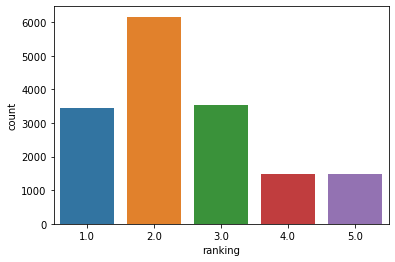

In [39]:
sns.countplot(data_prueba.ranking)

Graficando las valoraciones, vemos que en esta sección las puntuaciones tienden a ser iguales o menores a 3, pocas criticas alcanzaron los valores mas altos

In [40]:
reader = Reader()

In [41]:
df1 = data_prueba[["username", "product_id", "ranking"]]

In [42]:
data_surprise = Dataset.load_from_df(df1[["username", "product_id", "ranking"]], reader)

Sepramos el dataset en entrenamiento y testeo, y luego entrenamos una algoritmo SVD

In [43]:
trainset, testset = train_test_split(data_surprise, test_size=.3)
svd = SVD()
svd.fit(trainset)
predictions = svd.test(testset)

### Evaluamos el modelo con la metrica elegida

In [44]:
accuracy.rmse(predictions)

RMSE: 0.9983


0.9983289917324152

El dataset presenta un error muy bajo, ya que 1 punto de diferencia en una escala del 1 al 5 no deberia generar grandes problemas al momento de recomendar juegos. Algunas de las razones por la que puedo inferir este bajo error son:

* Al ser un escala de valoración del 1 al 5, se reduce la posibilidad de error. Si fuera una escala mas grande, capaz del 1 al 10, seguramente el error aumentaria.

* La gran cantidad de pocas criticas por usuarios tambien favorecen a que el error sea bajo, ya que el mismo se define como la predicción/el resultado real, por lo que si tuviera mas criticas por ususario, seguramente el error aumentaria.

* Tambien, en este genero, la mayoria de las criticas se encuentran entre valores del 1 al 3, siendo el 2 el valor mas frecuente. Eso favorece a que el error sea bajo vs un dataset con los datos mejor distribuidos

### Probamos los resultados

Probamos los resultados con el usuario "tanelorn", que juego le recomendarian en función de sus registros

In [45]:
usuario =  "tanelorn"

In [46]:
data_prueba[data_prueba.username == usuario]

,username,products,product_id,hours,ranking,Massively Multiplayer,Web Publishing,Indie,Casual,Audio Production,...,Racing,Education,Photo Editing,Action,RPG,Free to Play,Design &amp; Illustration,Early Access,Video Production,Animation &amp; Modeling
119,tanelorn,133.0,344340,145.2,5.0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [47]:
data_g[data_g.product_id == str(344340)]

,product_id,app_name,genres
27465,344340,Front Office Football Seven,"[Indie, Simulation, Sports, Strategy]"


In [48]:
recomendaciones_usuario = pd.DataFrame()
recomendaciones_usuario["product_id"] = data_prueba["product_id"].unique()
recomendaciones_usuario['Estimate_Score'] = recomendaciones_usuario['product_id'].apply(lambda x: svd.predict(usuario, x).est)
recomendaciones_usuario = recomendaciones_usuario.sort_values('Estimate_Score', ascending=False)   
for recomendacion in recomendaciones_usuario[0:4]["product_id"].unique():
    print(recomendacion)
    game = data_g[data_g.product_id == str(recomendacion)].app_name
    print(game)

482730
7851    Football Manager 2017
Name: app_name, dtype: object
385760
7297    NBA 2K17
Name: app_name, dtype: object
624090
14193    Football Manager 2018
Name: app_name, dtype: object
216260
28808    Don Bradman Cricket 14
Name: app_name, dtype: object


In [49]:
recomendaciones_usuario = pd.DataFrame()
recomendaciones_usuario["product_id"] = data_prueba["product_id"].unique()
recomendaciones_usuario['Estimate_Score'] = recomendaciones_usuario['product_id'].apply(lambda x: svd.predict(usuario, x).est)
recomendaciones_usuario = recomendaciones_usuario.sort_values('Estimate_Score', ascending=True)   
for recomendacion in recomendaciones_usuario[0:4]["product_id"].unique():
    print(recomendacion)
    game = data_g[data_g.product_id == str(recomendacion)].app_name
    print(game)

272890
3641    Vertiginous Golf
Name: app_name, dtype: object
449050
24097    Rock Paper Scissors Champion
Name: app_name, dtype: object
244930
1648    SNOW
Name: app_name, dtype: object
457330
7600    High Octane Drift
Name: app_name, dtype: object


Podemos ver que dentro del top 4 recomendados encontramos varios juegos de futbol, mientras que en los menos recomendados encontramos juegos de piedra, papel y tijera y un juego de carrera de animales. Podemos intuir que no existe relación con el registro que tenemos

### Mejoramos los hiperparametros 

In [50]:
from surprise.model_selection import GridSearchCV

param_grid = {
    'n_factors':[1, 2, 3],
    'n_epochs':[20, 30, 40],
}

gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv = 5, n_jobs = -1)
gs.fit(data_surprise)

In [51]:
print("Mejor score:")
print(gs.best_score['rmse'])
print("Mejores parametros:")
print(gs.best_params['rmse'])

Mejor score:
0.9974421570612556
Mejores parametros:
{'n_factors': 2, 'n_epochs': 40}


En general podemos ver que los resultados son muy buenos y en la optimización de hiperparametros no se genera un gran cambio

## 4. Modelo de SVD con otro genero

Como mencionamos durante la sección anterior, la división por genero supondria una mejor manera de trabajar con los datos y ayudaria a las recomendaciones, ya que solo se limitarian a juegos similares en genero. El error obetenido fue bastante bajo, y se propuso ciertas razones por lo cual podria estar ocurriendo, pero para estar seguros, realizaremos nuevamente la misma sección pero con otro genero

Este dataset tiene 333009 registros
El porcentaje de usuarios son un solo valor es de 62.68 %
La cantidad de juegos son 8000


C:\Users\Abel_\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='ranking', ylabel='count'>

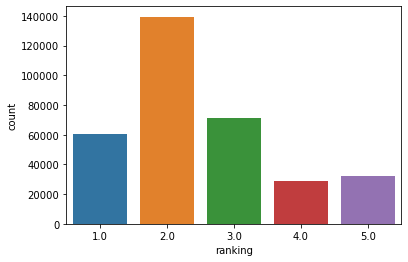

In [52]:
genero = "Indie"
data_prueba = data
mask_prueba = (data_prueba.ranking >= 1)
mask_prueba_2 = (data_prueba[genero] == 1)
data_prueba = data_prueba[mask_prueba & mask_prueba_2]
print("Este dataset tiene {} registros".format(data_prueba.shape[0]))
list_count_sport = data_prueba["username"].value_counts().to_numpy()
cantidad_juegos = len(data_prueba["product_id"].unique())
pd_list_sport = pd.DataFrame()
pd_list_sport["counts"] = list_count_sport
porc_one = round((pd_list_sport[pd_list_sport.counts == 1].shape[0]/data_prueba.shape[0])*100, 2)
print("El porcentaje de usuarios son un solo valor es de {} %".format(porc_one))
print("La cantidad de juegos son {}".format(cantidad_juegos))
sns.countplot(data_prueba.ranking)

In [53]:
reader2 = Reader()

In [54]:
df2 = data_prueba[["username", "product_id", "ranking"]]
data_surprise2 = Dataset.load_from_df(df2[["username", "product_id", "ranking"]], reader2)

In [55]:
trainset, testset = train_test_split(data_surprise2, test_size=.3)
svd = SVD()
svd.fit(trainset)

In [56]:
predictions = svd.test(testset)
accuracy.rmse(predictions)

RMSE: 0.8882


0.8881646498554497

Podemos notar que el error con este genero es levemente mayor que con el genero "Sports", utilizando el mismo modelo de SVD. Este genero tiene menos usuarios unicos (aunque sigue siendo una gran cantidad) y sus calificaciones estan mejor distribuidas, tambien es un genero que tiene muchos mas registros por lo cual podria estar influyendo en el aumento del error. 

## 5. Investigación - Filtro colaborativo sin librerias

En las secciones anteriores, vimos como funciona y los resultados de un filtro colaborativo basado en la libreria surprise. Trate de entender como funciona esta libreria y su metodologia pero no encontre la información suficiente. Leyendo y realizando un curso con el español Juan Gabriel Gomilla, puedo intuir que se basa en filtros colaborativos basados en usuarios, osea que busca usuarios similares para basar su recomendación y predecir los gustos a partir de estos usuarios semejantes.

En esta sección busco ver las recomendaciones de un filtro colaborativo basado en items. Como no encontre librerias para realizarlo, utilizare matematicas y, para comparar y facilitar el trabajo por el tamaño de la información, utilizare el genero Sports.

### Creamos una matriz de usuarios y juegos

In [57]:
genero = 'Sports'

In [58]:
mask = (data[genero] == 1)
usuarios = data[mask].username.unique()
games = data[mask].product_id.unique()
n_usuarios = len(usuarios)
n_games = len(games)
mu = pd.DataFrame(np.zeros((n_usuarios, n_games)), index = usuarios, columns = games).astype(pd.SparseDtype('float'))
mu.head()

,344340,8790,645750,528640,326590,316700,234710,339790,71240,492340,...,562700,627450,462110,398640,254440,538840,339610,566990,232910,518790
tanelorn,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
regan_uliski,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
dontforget101,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Joeyboots80,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DangerRyan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [59]:
mu.shape

(15438, 474)

Con la matriz realizada, vamos a colocar la calificación de los usuarios

In [60]:
for column in mu:
    spdtypes = mu.dtypes[column]
    mu[column] = mu[column].sparse.to_dense()
    mask_calif = data.product_id == column
    calif_colum = data[mask_calif]
    
    mu[column].loc[calif_colum.username.values] = calif_colum.ranking.values
    
    mu[column] = mu[column].astype(spdtypes)

C:\Users\Abel_\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Users\Abel_\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Users\Abel_\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 

C:\Users\Abel_\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Users\Abel_\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Users\Abel_\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 

C:\Users\Abel_\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Users\Abel_\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Users\Abel_\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 

C:\Users\Abel_\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Users\Abel_\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Users\Abel_\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 

C:\Users\Abel_\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Users\Abel_\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Users\Abel_\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 

C:\Users\Abel_\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Users\Abel_\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Users\Abel_\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 

C:\Users\Abel_\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Users\Abel_\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Users\Abel_\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 

C:\Users\Abel_\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Users\Abel_\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Users\Abel_\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 

C:\Users\Abel_\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Users\Abel_\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Users\Abel_\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 

C:\Users\Abel_\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Users\Abel_\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Users\Abel_\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 

C:\Users\Abel_\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Users\Abel_\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Users\Abel_\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 

In [61]:
mu.head()

,344340,8790,645750,528640,326590,316700,234710,339790,71240,492340,...,562700,627450,462110,398640,254440,538840,339610,566990,232910,518790
tanelorn,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
regan_uliski,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
dontforget101,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Joeyboots80,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DangerRyan,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Renombramos las columnas

Para trabajar mas comodo, vamos a renombrar las columnas con el nombre del juego, para lo que vamos a utilizar un pequeño bucle for para crear el diccinario necesario para renombrar

In [62]:
names_columns = {}
columns_mu = mu.columns
for c in columns_mu:
    mask_g = data_games.id == str(c)
    names_columns[c] = data_games[mask_g].values[0][2]

mu.rename(columns = names_columns,
               inplace=True)

In [63]:
mu.head()

,Front Office Football Seven,GTR 2 FIA GT Racing Game,Rule with an Iron Fish - A Pirate Fishing Adventure,Rugby Union Team Manager 2017,Cinemaware Anthology: 1986-1991,Front Page Sports Football,Poker Night 2,rFactor,SEGA Bass Fishing,Pixel Cup Soccer 17,...,Paintball 707,RUGBY 18,3 Coins At School,Bowl Bound College Football,Pool Nation,City Climber,Freestyle 2: Street Basketball,Russian Car Driver,TrackMania² Stadium,theHunter: Call of the Wild™
tanelorn,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
regan_uliski,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
dontforget101,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Joeyboots80,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DangerRyan,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [64]:
mu_np = mu.to_numpy()
sparsity = float(len(mu_np.nonzero()[0]))
sparsity /= (mu_np.shape[0]*mu_np.shape[1])
sparsity = round(sparsity*100, 2)
sparsity

0.22

In [65]:
print("Coeficiente de sparsidad {} % ".format(sparsity))

Coeficiente de sparsidad 0.22 % 


Este coeficiente busca ver que porcentaje de la matriz no son 0, como vemos es bastante pequeño. Una forma de interpretar este resultado es que "Muchos usuarios aun no han jugado muchos de los juegos disponibles"

Usaremos un modelo basado en KNN

In [66]:
n_games = mu.shape[1]

In [67]:
from sklearn.neighbors import NearestNeighbors

In [68]:
neighbors_games = NearestNeighbors(n_games, 'cosine')

C:\Users\Abel_\Anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass n_neighbors=474, radius=cosine as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


In [69]:
neighbors_games.fit(mu.T)

NearestNeighbors(n_neighbors=474, radius='cosine')

Es importante ver que el modelo entrena con la matriz transpuesta, ya que busca aprender sobre los items, y no de los usuarios. Esto genera que tenga menos registros (ya que seria uno por juego), pero tendria muchas calificaciones de distintos usuarios

Calculamos la distancia entre juegos y el top de juegos mas similares de cada uno

In [70]:
top_k_distance, top_k_games = neighbors_games.kneighbors(mu.T, return_distance = True)

In [71]:
top_k_distance

array([[  0.        ,  14.73091986,  14.73091986, ...,  76.5049018 ,
         81.        ,  86.98850499],
       [  0.        ,   2.82842712,   2.82842712, ...,  75.12655988,
         79.69943538,  85.77878526],
       [  0.        ,   3.60555128,   3.60555128, ...,  75.1598297 ,
         79.73079706,  85.80792504],
       ...,
       [  0.        ,   9.53939201,   9.53939201, ...,  75.67694497,
         80.21845174,  86.26123115],
       [  0.        ,  32.92415527,  32.92415527, ...,  81.85352772,
         86.18584571,  91.83681179],
       [  0.        ,  55.66866264,  55.74047004, ...,  93.37558567,
         97.21625379, 102.00490184]])

Podemos ver la matriz de la distancia coseno entre cada juego y los demas. El primer elemento de la array es un 0 ya que la distancia de cada juego con si mismo es 0

In [72]:
top_k_games

array([[  0, 101,  99, ..., 303,  22, 298],
       [  1, 220, 188, ..., 303,  22, 298],
       [  2, 196, 326, ..., 303,  22, 298],
       ...,
       [471, 109, 130, ..., 303,  22, 298],
       [472, 421, 422, ..., 303,  22, 298],
       [473, 329, 109, ..., 303,  22, 298]], dtype=int64)

En esta matriz podemos ver la lista de juegos recomendada basada en el primer juego. Podemos ver que los ultimos valores son los mismos, ya que seguramente son los juegos menos jugados

### Resultados del usuario "tanelorn" - Juego  "Front Office Football Seven"

Vamos a ver los resultados de recomendación para el usuario Tenelorn que solo jugo al juego Front Office Football Seven. En este caso seria el juego numero 0 de la lista (Ya que es la primera columna)

In [74]:
print(mu.columns[0])
print(mu.columns[101])
print(mu.columns[99])

Front Office Football Seven
FROG X BIRD
TOTOBALL


In [75]:
print(mu.columns[298])
print(mu.columns[22])
print(mu.columns[303])

SpeedRunners
TEKKEN 7
Golf With Your Friends


A diferencia de la libreria surprise, los juegos recomendados no son de football, sino de otros tipos.

## 6. Analisis de resultados finales

Con respecto al modelo basado en la libreria surprise, podemos notar que en terminos de error cuadratico el modelo como la metodologia de dividir por generos dio muy buenos resultados.

Como critica al modelo, cuestiono si los buenos resultados no esta en gran medida influidos por la cantidad de registros unicos. Seria bueno explorar este resultados en un dataset con muchos mas registros por usuarios

Con respecto a la investigación, me parecio interesante plantear utilizar la distancia coseno para ver juegos similares. Hacer un filtro colaborativo basado en items podria capaz ser mejor opción en casos como estos, que muchos usuarios han jugado a pocos juegos de la lista. Busque y me apoye en otros cursos para tratar de estudiar como implementar una metrica de evaluación, pero fueron pocos claros la aplicación por lo cual me parecio pertinente no aplicarlos en este trabajo. 